In [3]:
import os # To check whether file exists
import json # To save GPS coordinates as a JSON file
from geopy.geocoders import Nominatim # To get districts' GPS coordinates
import numpy as np # Math stuff
from matplotlib import pyplot as plt # To plot histogram

In [4]:
# To compute distance between two (lat,long) coords on the globe (for those of us who believe the earth is round)
def haversine_distance(lat1, long1, lat2, long2):
    phi1 = (90.0 - lat1)*np.pi/180.0
    phi2 = (90.0 - lat2)*np.pi/180.0
    theta1 = long1*np.pi/180.0
    theta2 = long2*np.pi/180.0
    cos = min(1,np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + np.cos(phi1)*np.cos(phi2))
    arc = np.arccos(cos)
    return 6373*arc
#end

In [5]:
# Obtain district names
district_names = [x.strip() for x in open('bairros.txt','r').readlines()]

In [6]:
# Obtain geolocator
geolocator = Nominatim()

/home/rafael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [8]:
# Save district locations to JSON file
if not os.path.isfile('district_locations.json'):
    district_locations = {}
    for district in district_names:
        location = geolocator.geocode(f'{district}, Porto Alegre')
        district_locations[district] = (location.latitude, location.longitude)
        print(f'{district} lat={location.latitude} lon={location.longitude}')
    #end
    json.dump(district_locations,open('district_locations.json','w'))
#end
district_locations = json.load(open('district_locations.json','r'))

In [9]:
# Compute dict mapping each district name to a list of (district,distance) tuples, sorted by distance
distances = { d1:sorted([ (d2,haversine_distance(*district_locations[d1],*district_locations[d2])) for d2 in district_names ], key=lambda x: x[1]) for d1 in district_names }

In [10]:
# Run a war simulation
def simulate():
    # Init map of occupations
    occupied_by = { district:district for district in district_names }

    # List of districts which are still in the game
    players = district_names.copy()

    while len(players) > 1:
        # Choose a random district
        random_district = np.random.choice(district_names)
        # Get closest enemy district
        for district,_ in distances[random_district]:
            if occupied_by[district] != occupied_by[random_district]:
                closest_enemy = district
                break
            #end
        #end
        # If random district is occupied, the occupier becomes the attacking district
        attacking_district = occupied_by[random_district]
        # If closest enemy is occupied, the occupier becomes the defending district
        defending_district = occupied_by[closest_enemy]
        # Closest enemy is now occupied by the attacking district
        occupied_by[closest_enemy] = attacking_district
        # If defending district occupies no districts, it is out of the game
        if not defending_district in occupied_by.values(): players.remove(defending_district);

        #print(f'{attacking_district}, através de {random_district}, conquista {closest_enemy} do {defending_district}')
    #end
    # Return winning district
    return players[0]
#end

In [12]:
# Run many simulations and keep track of the winners
simulations = 10**3
wins = { district:0 for district in district_names }
for i in range(simulations):
    winner = simulate()
    wins[winner] += 1
#end

#1	| Lami                    has won 88 wars 	| (8.80% total)
#2	| Extrema                 has won 83 wars 	| (8.30% total)
#3	| Santa Rosa de Lima      has won 51 wars 	| (5.10% total)
#4	| Arquipélago             has won 38 wars 	| (3.80% total)
#5	| Rubem Berta             has won 35 wars 	| (3.50% total)
#6	| Boa Vista do Sul        has won 35 wars 	| (3.50% total)
#7	| Lageado                 has won 29 wars 	| (2.90% total)
#8	| São Caetano             has won 26 wars 	| (2.60% total)
#9	| Vila Conceição          has won 23 wars 	| (2.30% total)
#10	| Pitinga                 has won 23 wars 	| (2.30% total)
#11	| Belém Novo              has won 21 wars 	| (2.10% total)
#12	| Serraria                has won 20 wars 	| (2.00% total)
#13	| Mário Quintana          has won 20 wars 	| (2.00% total)
#14	| Morro Santana           has won 20 wars 	| (2.00% total)
#15	| Anchieta                has won 20 wars 	| (2.00% total)
#16	| Vila Assunção           has won 19 wars 	| (1.90% total)
#

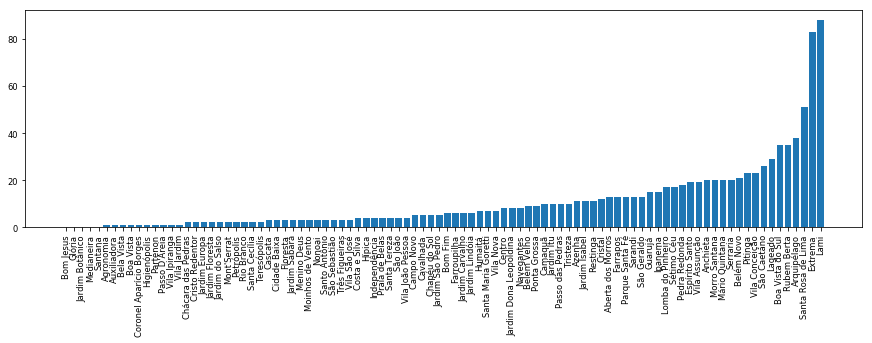

In [27]:
# Print results
sorted_districts = sorted(district_names, key=lambda x: wins[x])
for i,district in enumerate(sorted_districts[::-1]):
    print(f'#{i+1}\t| {str(district).ljust(23)} has won {wins[district]} wars \t| ({"%.2f" % (100*wins[district]/simulations)}% total)')
#end

# Plot histogram
fig,ax = plt.subplots(figsize=(15,4))
ax.bar(sorted_districts, [wins[x] for x in sorted_districts])
plt.xticks(rotation='vertical')
ax.tick_params(labelsize='small')
plt.show()